In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

2024-06-10 19:07:52.145525: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 19:07:53.131546: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [3]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['archive/seg_train/seg_train', 'archive/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading archive/seg_train/seg_train


100%|██████████| 2404/2404 [00:00<00:00, 3043.28it/s]


Loading archive/seg_test/seg_test


100%|██████████| 553/553 [00:00<00:00, 3418.19it/s]


In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


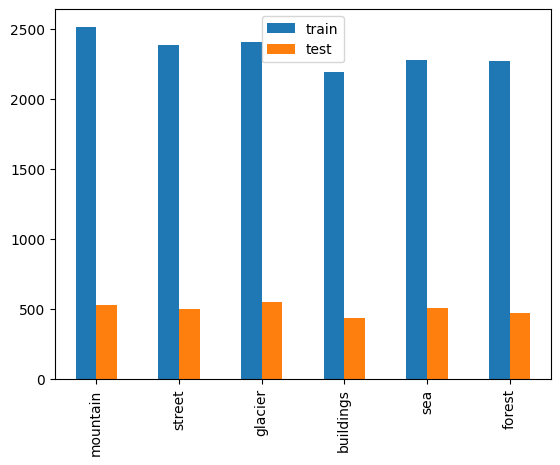

In [7]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()


In [8]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu',  input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model.summary()

/home/diana/anaconda3/envs/taa/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-10 18:19:54.584999: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-10 18:19:54.586159: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to dow

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 906,214 (3.46 MB)

 Trainable params: 906,214 (3.46 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20


2024-06-10 18:20:52.718484: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3031290000 exceeds 10% of free system memory.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4500 - loss: 1.3347

2024-06-10 18:22:27.037387: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 757890000 exceeds 10% of free system memory.


88/88 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.4511 - loss: 1.3325 - val_accuracy: 0.6124 - val_loss: 1.0388
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.6670 - loss: 0.8919 - val_accuracy: 0.7171 - val_loss: 0.7497
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.7427 - loss: 0.6970 - val_accuracy: 0.7421 - val_loss: 0.6736
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.7939 - loss: 0.5692 - val_accuracy: 0.7674 - val_loss: 0.6410
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.8144 - loss: 0.5054 - val_accuracy: 0.8076 - val_loss: 0.5514
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.8458 - loss: 0.4323 - val_accuracy: 0.7991 - val_loss: 0.5603
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.8399 - loss: 0.4457 - val_accuracy: 0.7870 - val_loss: 0.6131
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.8690 - loss: 0.3727 - val_accuracy: 0.8183 - val_loss: 0.5524

In [13]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(15, 10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'], label = "Train Accuracy")
    plt.plot(history.history['val_accuracy'], label = "Validation Accuracy")
    plt.title("Train Accuracy vs Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'], label = "Train Loss")
    plt.plot(history.history['val_loss'], label = "Validation Loss")
    plt.title("Train Loss vs Validation Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")

    plt.legend()
    plt.show()

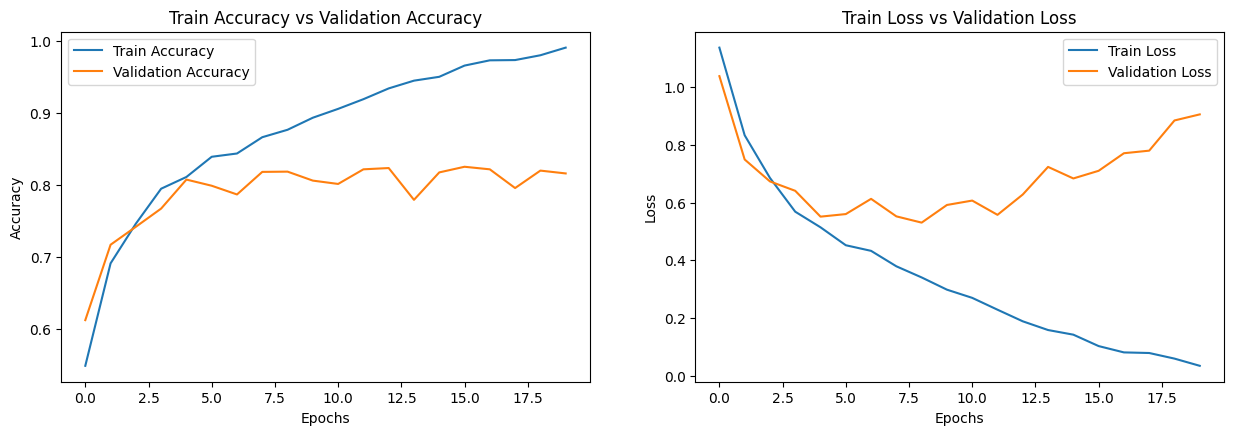

In [14]:
plot_accuracy_loss(history)

In [15]:
test_loss = model.evaluate(test_images, test_labels)

 2/94 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9844 - loss: 0.0389

2024-06-10 18:54:39.931968: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 810000000 exceeds 10% of free system memory.


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8713 - loss: 0.5946


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step


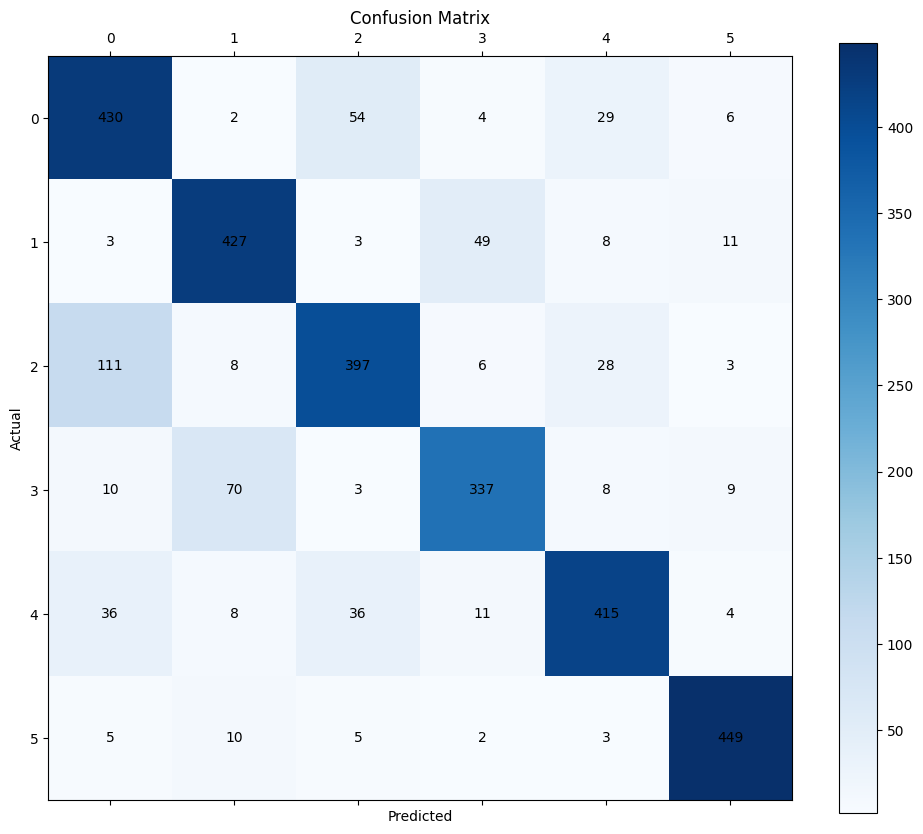

In [19]:
# Confusion Matrix
predictions = model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)
confusion = confusion_matrix(test_labels, y_pred)

fig, ax = plt.subplots(figsize=(12, 10)) 
cax = ax.matshow(confusion, cmap='Blues')
fig.colorbar(cax)

for (i, j), val in np.ndenumerate(confusion):
    ax.text(j, i, f'{val}', ha='center', va='center')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()